In [3]:
import os
import sys

# Ensure no W&B logging will be performed
sys.argv = "main.py -log tb -name tst -reset 1 -lm.eval.enable 0 -log tb -batch_size 20 -restore /cm/shared/anonymous/moeut_training_code/save/slimpajama_moe_no_attmoe_154M_standard_lb/checkpoint/model-100000.pth".split(" ")
# sys.argv = "main.py -log tb -name tst -reset 1 -lm.eval.enable 0 -log tb -batch_size 20 -restore paper/moe_universal/checkpoints/plvywltl/model.ckpt".split(" ")

# Pretend we are in the main directory
os.chdir("../../")

In [5]:
from main import initialize
import torch
import torch.nn.functional as F
from layers import MoE

print(MoE)

<class 'layers.moe_layer.MoE'>


In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['text.usetex'] = False #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = '\\usepackage{sansmath}\n\\sansmath' #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # Change from 'Arial' to 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif' # Choose a nice font here

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

In [7]:
helper, task = initialize()
task.create_data_fetcher()

orig_run_model_valid = task.run_model_validation

Restoring: /cm/shared/anonymous/moeut_training_code/save/slimpajama_moe_no_attmoe_154M_standard_lb/checkpoint/model-100000.pth...
No distributed environment detected
Resetting training state...
Port already used: 7000
Port already used: 7001
Port already used: 7002
Found tensorboard in /cm/archive/anonymous/miniconda3/envs/moeut/bin/tensorboard
Starting Tensorboard server on 7003
Done.
SlimPajama: Generating map...
Map done.
SlimPajama: Loaded tokenizer.
SlimPajama: 58345 chunks missing
Token limit reached. No need to tokenize more.
SlimPajama: Limiting to first 164 chunks because limited to 2050048000 tokens
SlimPajama: Loaded tokenizer.
SlimPajama: 31345 chunks missing
Token limit reached. No need to tokenize more.
SlimPajama: Limiting to first 59 chunks because limited to 1032192 tokens
Weight info:
  n_model_weights: 149733376
  n_attention_weights: 10747904
  n_non_attnetion_weights: 138985472
  attention_precent: 0.0717802823065981
Training in bfloat16...
Total number of model pa

/cm/shared/anonymous/moeut_training_code/tasks/lm_base.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  data = torch.tensor(res, dtype=torch.long, device=self.helper.device).T


In [8]:
nexp = task.helper.args.moe.n_experts
ntok = task.helper.args.sentencepiece.n_pieces
ngrp = task.helper.args.transformer.universal.group_size
nlayers = task.helper.args.transformer.encoder_n_layers

token_counts = 0

counts = torch.zeros(ngrp, nlayers // ngrp, nexp, ntok)

In [9]:
global this_data

def run_model_validation(self, data):
    global token_counts
    global this_data

    token_counts = token_counts + F.one_hot(data["data"].flatten().long(), ntok).sum(0)

    this_data = data
    return orig_run_model_valid(data)

task.run_model_validation = run_model_validation.__get__(task)

In [10]:
id_map = {}

def patch_module(module):

    myid = id(module)
    if myid in id_map:
        return

    gid = len(id_map)
    id_map[myid] = gid

    # sel_val, sel_index = self.topk(

    def new_topk(self, *args, **kwargs):
        global this_data
        gid = id_map[id(self)]
        data = this_data["data"][:-1].T

        sel_val, sel_index = MoE.topk(self, *args, **kwargs)

        assert data.shape == sel_index.shape[:-1]

        data = data.reshape(-1)

        # Shape of counts[gid]: nexp, ntok
        # Linear index: expert * ntok + tok

        seli = sel_index.flatten(end_dim=-2) * ntok
        addi = seli + data[..., None]
        addi = addi.flatten().cpu()

        counts[gid][self.layer // ngrp].flatten().index_add_(0, addi, torch.ones_like(addi, dtype=torch.float32))

        return sel_val, sel_index


    module.topk = new_topk.__get__(module)


In [11]:
for m in task.model.modules():
    if isinstance(m, MoE):
        patch_module(m)

In [12]:
task.validate()

Starting validation on val...


  0%|          | 0/100 [00:00<?, ?it/s]

New shape: (torch.Size([10, 1024, 512]), torch.Size([66, 512, 128]))
New shape: (torch.Size([10, 1024, 8, 128]), torch.Size([66, 128, 512]))


100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

Validation done on worker 0.
Validation accuracy on val: 0.477939453125


{'val/loss': 2.619261329650879,
 'val/accuracy': 0.477939453125,
 'val/perplexity': 13.725581159757501,
 'val/time_since_best_loss': 0,
 'val/time_since_best_accuracy': 0,
 'mean_accuracy': 0.477939453125,
 'mean_loss': 2.6192613220214844}

In [13]:
order = torch.argsort(token_counts, descending=True).cpu()
token_counts_o = token_counts.cpu()[order]
counts_o = counts[:, :, :, order]

Plot slice shape torch.Size([100, 66])


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: H

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: H

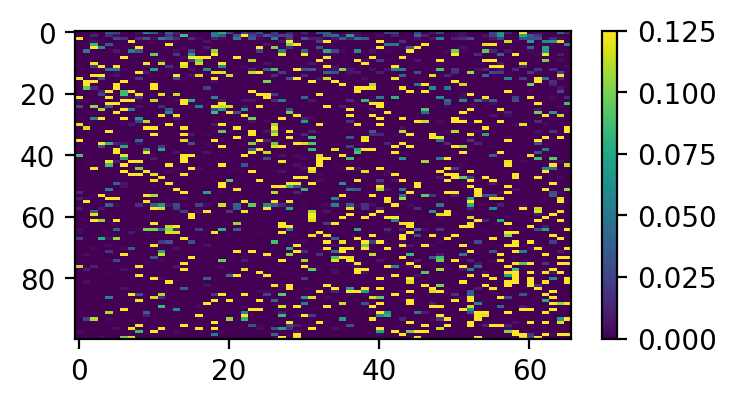

In [18]:
ostart = 0000
count = 100
gid = 0
layer = 0

labels = task.train_set.vocabulary(order[ostart:ostart+count].tolist())

fig, ax=plt.subplots(figsize=(4, 2))
if layer is None:
    plot_slice = counts_o[gid, :, :, ostart:ostart+count]
    plot_slice = plot_slice.sum(0)
else:
    plot_slice = counts_o[gid, layer, :, ostart:ostart+count]

plot_slice = plot_slice / plot_slice.sum(0, keepdim=True)

plot_slice = plot_slice.T


print("Plot slice shape", plot_slice.shape)

tresh = torch.quantile(plot_slice, 0.95, dim=0, keepdim=True)
# tresh = 0
total_counts = plot_slice * (plot_slice >= tresh)
total_counts = total_counts / total_counts.sum(0, keepdim=True)
# plot_slice = total_counts
total_counts = total_counts * torch.arange(plot_slice.shape[0], dtype=torch.float)[..., None]
total_counts = total_counts.sum(0)
order3 = total_counts.argsort(descending=False)

# print(total_coints[order3])

plot_slice_o = plot_slice[:, order3]
# plot_slice_o = plot_slice_o.T


# plot_slice_o = plot_slice


plt.imshow(plot_slice_o.numpy(), aspect='auto', cmap='viridis', interpolation="none")
plt.colorbar()
# plt.yticks(range(count), labels)

In [19]:
my_dist = counts[gid][-1]#.sum(0)
# My dist shape: n_exp, n_tok

d = 0
# my_dist_n = my_dist / my_dist.sum(d, keepdim=True)
# entropy = (- my_dist_n.clip(min=torch.finfo(my_dist_n.dtype).eps).log() * my_dist_n).sum(d)
cnt = (my_dist > 0).sum(0)
eid = cnt.argsort(descending=True)

eid = eid[cnt[eid]>0]

# eid = (entropy).argsort()
# entropy[eid]



In [20]:
task.train_set.vocabulary(eid[:300].cpu().numpy().tolist())

[',',
 '.',
 '▁the',
 '_',
 '0',
 '▁',
 '▁I',
 '▁and',
 '-',
 '▁is',
 '1',
 '▁a',
 '2',
 '"',
 '<unk>',
 "'",
 '>',
 '9',
 '▁$',
 'STORY',
 '▁"',
 '▁M',
 '▁&',
 '▁The',
 'F',
 '▁of',
 's',
 '▁(',
 'a',
 '▁de',
 ':',
 '4',
 'J',
 '8',
 '6',
 '▁You',
 '▁-',
 '▁to',
 '▁was',
 '▁fixed',
 '▁nom',
 '3',
 ';',
 '▁N',
 'c',
 '?',
 '▁{',
 'l',
 '▁develop',
 '▁class',
 '▁We',
 '▁=',
 'ol',
 'T',
 '▁our',
 '▁L',
 '▁its',
 '▁his',
 ')',
 '(',
 'G',
 '5',
 '▁in',
 '▁history',
 'é',
 '▁f',
 '▁shall',
 '▁m',
 't',
 'h',
 'd',
 '▁using',
 'SEP',
 '▁that',
 '▁D',
 'ment',
 '▁your',
 'ations',
 '▁den',
 '▁we',
 '▁Just',
 'H',
 '▁this',
 '▁R',
 '▁he',
 '▁w',
 'at',
 '▁stars',
 '▁No',
 '▁rec',
 '▁study',
 're',
 '▁t',
 '▁similar',
 'p',
 '▁A',
 '▁she',
 'I',
 '$',
 '▁where',
 '▁que',
 '▁way',
 '▁are',
 '▁path',
 '▁action',
 '▁should',
 '▁un',
 '▁just',
 'ar',
 'ed',
 'pm',
 '▁tra',
 'art',
 '▁which',
 '▁J',
 '▁comp',
 'ind',
 'ong',
 '▁garden',
 '▁their',
 ']',
 '▁follows',
 '▁leads',
 '▁game',
 'St',
 '▁

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: H

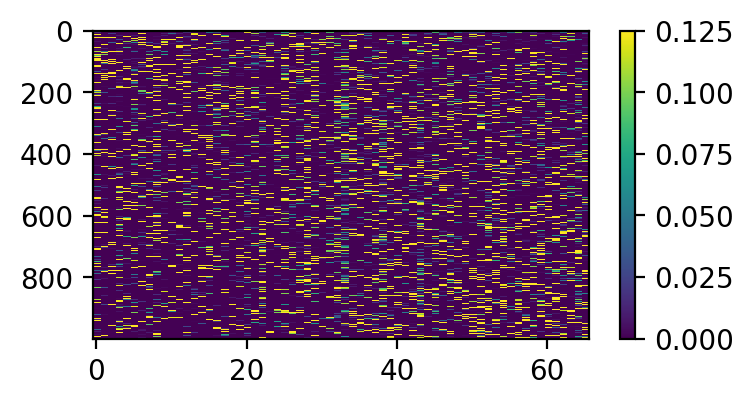

In [21]:
my_dist_curr = my_dist[:, eid[00:1000]]
my_dist_curr = my_dist_curr / my_dist_curr.sum(0, keepdim=True)

my_dist_curr = my_dist_curr.T
tresh = torch.quantile(my_dist_curr, 0.98, dim=0, keepdim=True)
# tresh = 0
total_counts = my_dist_curr * (my_dist_curr >= tresh)
total_counts = total_counts / total_counts.sum(0, keepdim=True)
# plot_slice = total_counts
total_counts = total_counts * torch.arange(my_dist_curr.shape[0], dtype=torch.float)[..., None]
total_counts = total_counts.sum(0)
order3 = total_counts.argsort(descending=False)
my_dist_curr = my_dist_curr[:, order3]

my_dist_curr = my_dist_curr.T


# my_dist_curr = my_dist_curr/my_dist_curr.sum(0, keepdim=True)
fig, ax=plt.subplots(figsize=(4, 2))
plt.imshow(my_dist_curr.T.numpy(), aspect='auto', cmap='viridis', interpolation="none")
plt.colorbar()

In [22]:
(my_dist_curr>0).sum(0)


tensor([57, 54, 53, 46, 40, 39, 38, 34, 34, 33, 32, 32, 29, 29, 28, 28, 28, 28,
        27, 26, 26, 25, 25, 25, 25, 24, 24, 24, 23, 23, 22, 22, 22, 22, 22, 22,
        22, 22, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
        18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 17, 

<BarContainer object of 1000 artists>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: H

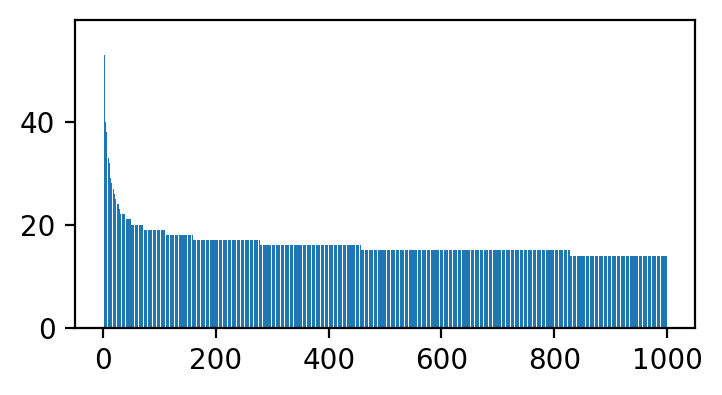

In [23]:
fig, ax=plt.subplots(figsize=(4, 2))
plt.bar(range(my_dist_curr.shape[1]), (my_dist_curr>0).sum(0))

In [24]:
counts.shape

torch.Size([16, 1, 66, 8000])

In [25]:
eused = counts[0].sum(-1) > 0

In [26]:
eused.sum(-1)

tensor([66])

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: H

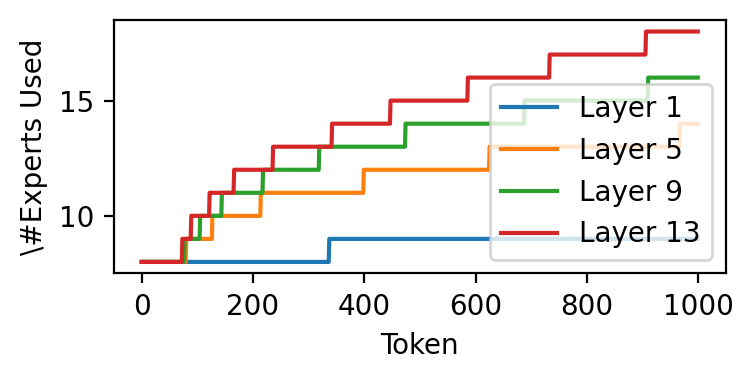

In [27]:
# gcnts = counts[gid]
gcnts = counts.permute(1,0,2,3).flatten(end_dim=1)

fig, ax=plt.subplots(figsize=(4, 2))
for i in range(gcnts.shape[0]):
    if i % 4 != 0: #and i != gcnts.shape[0]-1:
        continue
    # if i not in {0,1,5,10,14,15,16,17}:
        # continue
    n_used = (gcnts[i] > 0).sum(0)
    order = n_used.argsort()

    order = order[n_used[order] > 0]

    plt.plot(n_used[order].numpy()[:1000], label=f"Layer {i+1}")

# plt.yscale("log")
# formatter = ScalarFormatter()
# formatter.set_scientific(False)
# plt.gca().yaxis.set_major_formatter(formatter)
# plt.gca().yaxis.set_minor_formatter(formatter)
plt.legend(loc='lower right')
plt.xlabel("Token")
plt.ylabel("\#Experts Used")
plt.tight_layout()
plt.savefig("paper/moe_universal/expert_count_per_token_per_layer.pdf", bbox_inches='tight')

In [28]:
gcnts = counts[gid]
gcnts.shape

torch.Size([1, 66, 8000])

In [29]:

sel_per_layer = (gcnts > 0).sum(1)

In [30]:
sel_per_layer.shape

torch.Size([1, 8000])

In [31]:
n_experts_pre_token_all_layers = (gcnts.sum(0) > 0).sum(0)

img = sel_per_layer / n_experts_pre_token_all_layers

In [32]:
img.shape

torch.Size([1, 8000])

In [33]:
order = torch.argsort(token_counts, descending=True).cpu()

imgo = img[:, order[:6000]]

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Avant Garde, Computer Modern Sans serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: H

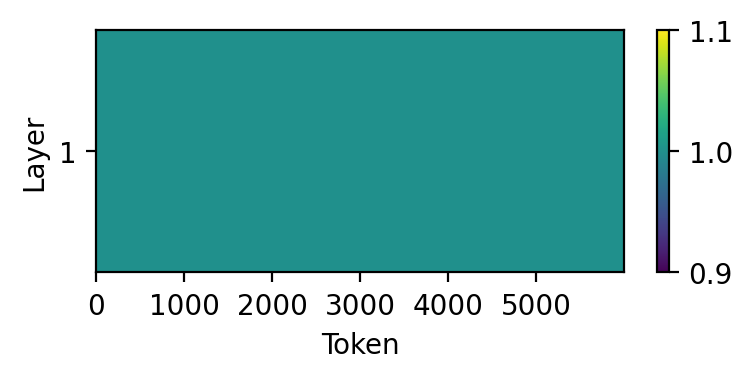

In [34]:
fig, ax=plt.subplots(figsize=(4, 2))
plt.imshow(imgo.numpy(), aspect='auto', cmap='viridis', interpolation="nearest")
plt.colorbar()
plt.xlabel("Token")
plt.yticks([a*2 + gid for a in range(nlayers // ngrp // 2 + 1)], [str(a*4 + 1 + gid) for a in range(nlayers // ngrp // 2+1)])
plt.ylabel("Layer")
plt.tight_layout()
plt.savefig("paper/moe_universal/experts_per_token_per_layer.pdf", bbox_inches='tight')